In [1]:
# For google colab
# ! pip install deeppavlov
# ! pip install pybind11

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import *
import copy
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

2018-08-30 12:55:29.278 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
TRAIN_ELMO = True
TRAIN_ALL_ELMO_PARAMS = True

In [4]:
def read_data():
    reader = OntonotesReader()
    dataset = reader.read(data_path='data/')
    # print(dataset.keys())
    print('Num of train sentences: {}'.format(len(dataset['train'])))
    print('Num of valid sentences: {}'.format(len(dataset['valid'])))
    print('Num of test sentences: {}'.format(len(dataset['test'])))
    print(dataset['train'][50:60])
    return dataset

def filter_data_by_ne_type(data:list, ne_types:list, tags2binary=False, preserveBIO=False, keepIfAny=True):
    if ne_types == None or len(ne_types) == 0:
        return data
    data_filtered = []
    for tokens,tags in data:
        contains_all = True
        contains_any = False
        tags_norm = [getNeTagMainPart(t) for t in tags]
        for ne_type in ne_types:
            if not ne_type in tags_norm:
                contains_all = False
            if ne_type in tags_norm:
                contains_any = True
        if contains_all or (keepIfAny and contains_any):
            if tags2binary:
                if preserveBIO:
                    tags = [tags[i][:2]+'T' if t in ne_types else 'O' for i,t in enumerate(tags_norm)]
                else:
                    tags = ['T' if t in ne_types else 'O' for t in tags_norm]
            data_filtered.append((tokens,tags))
    return data_filtered

def filter_dataset_by_ne_types(dataset: list, ne_types, preserveBIO=False, keepIfAny=True):
    dataset = copy.deepcopy(dataset)
    if not isinstance(ne_types, list):
        ne_types = [ne_types]
    for dataset_type in ['train', 'valid', 'test']:
        dataset[dataset_type] = filter_data_by_ne_type(dataset[dataset_type], ne_types, preserveBIO=preserveBIO, tags2binary=True)
        print('Num of {} sentences: {}'.format(dataset_type, len(dataset[dataset_type])))
    return dataset

def get_data_sample(data, n_samples: int):
    indices = np.random.choice(len(data), size=n_samples, replace=False)
    return split_tokens_tags([data[i] for i in indices])

def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')
  
def getNeTagMainPart(tag:str):
    return tag[2:] if tag != 'O' else tag

def tags2binaryFlat(tags):
    return np.array([1 if t == 'T' or (len(t) > 2 and t[2:] == 'T') else 0 for seq in tags for t in seq])

def tags2binaryPadded(tags:list):
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    tokens_length = np.tile(np.expand_dims(tokens_length, -1), (1,max_len))
    y = np.zeros((n_sentences, max_len))
    range_ar = np.tile(np.arange(1, max_len+1, 1), (n_sentences, 1))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if tags[i][j] != 'O':
                y[i][j] = 1
#     y[range_ar > tokens_length] = -1
    return y

def get_matrices(tokens, tags, embedder):
    return (embeddings2feat_mat(embedder.embed(tokens), get_tokens_len(tokens)),
           tags2binaryFlat(tags))
  
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

In [5]:
dataset_orig = read_data()
# ne_type = 'PERSON'
# ne_types = ['GPE','DATE','ORG','EVENT','LOC','FAC','CARDINAL','QUANTITY','NORP','ORDINAL','WORK_OF_ART']
ne_types = ['GPE','DATE','ORG','EVENT','LOC','FAC','CARDINAL','QUANTITY','NORP','ORDINAL','WORK_OF_ART', 'LANGUAGE', 'TIME', 'PRODUCT', 'MONEY', 'LAW', 'PERCENT']
# dataset = {'train':[], 'valid':[], 'test':[]}
# for ne_type in ne_types:
#     print(ne_type)
#     dataset_cur = filter_dataset_by_ne_types(dataset_orig, ne_type)
#     for k in dataset.keys():
#         dataset[k].extend(dataset_cur[k])
dataset = filter_dataset_by_ne_types(dataset_orig, ne_types, keepIfAny=True)
print('Number of sentences in filtered dataset: train: {}, valid: {}, test: {}'.format(len(dataset['train']), len(dataset['valid']), len(dataset['test'])))

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [6]:
# dataset_zipped = [list(zip(tokens, tags)) for tokens,tags in dataset['train']]
# for sent in dataset_zipped:
#   for token, tag in sent:
#     print('{}\t{}'.format(token, tag))
#   print()

In [7]:
INITIALIZER = tf.contrib.layers.xavier_initializer

def bi_rnn(units: tf.Tensor,
           n_hidden: List,
           cell_type='gru',
           seq_lengths=None,
           trainable_initial_states=False,
           use_peepholes=False,
           name='Bi-'):
    """ Bi directional recurrent neural network. GRU or LSTM

        Args:
            units: a tensorflow tensor with dimensionality [None, n_tokens, n_features]
            n_hidden_list: list with number of hidden units at the ouput of each layer
            seq_lengths: length of sequences for different length sequences in batch
                can be None for maximum length as a length for every sample in the batch
            cell_type: 'lstm' or 'gru'
            trainable_initial_states: whether to create a special trainable variable
                to initialize the hidden states of the network or use just zeros
            use_peepholes: whether to use peephole connections (only 'lstm' case affected)
            name: what variable_scope to use for the network parameters
            add_l2_losses: whether to add l2 losses on network kernels to
                tf.GraphKeys.REGULARIZATION_LOSSES or not
        Returns:
            units: tensor at the output of the last recurrent layer
                with dimensionality [None, n_tokens, n_hidden_list[-1]]
            last_units: tensor of last hidden states for GRU and tuple
                of last hidden stated and last cell states for LSTM
                dimensionality of cell states and hidden states are
                similar and equal to [B x 2 * H], where B - batch
                size and H is number of hidden units
    """

    with tf.variable_scope(name + '_' + cell_type.upper()):
        if cell_type == 'gru':
            forward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.GRUCell(n_hidden, kernel_initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
                initial_state_bw = tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1))
            else:
                initial_state_fw = initial_state_bw = None
        elif cell_type == 'lstm':
            forward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            backward_cell = tf.nn.rnn_cell.LSTMCell(n_hidden, use_peepholes=use_peepholes, initializer=INITIALIZER())
            if trainable_initial_states:
                initial_state_fw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_fw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_fw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
                initial_state_bw = tf.nn.rnn_cell.LSTMStateTuple(
                    tf.tile(tf.get_variable('init_bw_c', [1, n_hidden]), (tf.shape(units)[0], 1)),
                    tf.tile(tf.get_variable('init_bw_h', [1, n_hidden]), (tf.shape(units)[0], 1)))
            else:
                initial_state_fw = initial_state_bw = None
        else:
            raise RuntimeError('cell_type must be either "gru" or "lstm"s')
        (rnn_output_fw, rnn_output_bw), (fw, bw) = \
            tf.nn.bidirectional_dynamic_rnn(forward_cell,
                                            backward_cell,
                                            units,
                                            dtype=tf.float32,
                                            sequence_length=seq_lengths,
                                            initial_state_fw=initial_state_fw,
                                            initial_state_bw=initial_state_bw)
    kernels = [var for var in forward_cell.trainable_variables +
               backward_cell.trainable_variables if 'kernel' in var.name]
    for kernel in kernels:
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(kernel))
    return (rnn_output_fw, rnn_output_bw), (fw, bw)

def build_cudnn_rnn(units, mask, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    sequence_lengths = tf.to_int32(tf.reduce_sum(mask, axis=1))
    for n, n_hidden in enumerate(n_hidden_list):
        with tf.variable_scope(cell_type.upper() + '_' + str(n)):
            if cell_type.lower() == 'lstm':
                units, _ = cudnn_bi_lstm(units, n_hidden, sequence_lengths)
            elif cell_type.lower() == 'gru':
                units, _ = cudnn_bi_gru(units, n_hidden, sequence_lengths)
            else:
                raise RuntimeError('Wrong cell type "{}"! Only "gru" and "lstm"!'.format(cell_type))
            units = tf.concat(units, -1)
            if intra_layer_dropout and n != len(n_hidden_list) - 1:
                units = variational_dropout(units, dropout_ph)
    return units

def build_rnn(units, n_hidden_list:Tuple[int]=(128,), cell_type:str='lstm', intra_layer_dropout:bool=False, dropout_ph=None):
    for n, n_hidden in enumerate(n_hidden_list):
        units, _ = bi_rnn(units, n_hidden, cell_type=cell_type, name='Layer_' + str(n))
        units = tf.concat(units, -1)
        if intra_layer_dropout and n != len(n_hidden_list) - 1:
            units = variational_dropout(units, dropout_ph)
    return units

def build_top(units, n_tags=1, top_dropout:bool=False, two_dense_on_top:bool=False, n_hidden=128):
    if top_dropout:
        units = variational_dropout(units, dropout_ph)
    if two_dense_on_top:
        units = tf.layers.dense(units, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=INITIALIZER(),
                                kernel_regularizer=tf.nn.l2_loss)
    logits = tf.layers.dense(units, n_tags, activation=None,
                             kernel_initializer=INITIALIZER(),
                             kernel_regularizer=tf.nn.l2_loss)
    return logits

def build_train_predict(logits, n_tags, mask, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg):
    res = {}
    if use_crf:
        sequence_lengths = tf.reduce_sum(mask, axis=1)
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(logits, y_ph, sequence_lengths)
        loss_tensor = -log_likelihood
        res['transition_params'] = transition_params
    else:
        ground_truth_labels = tf.one_hot(y_ph, n_tags)
        loss_tensor = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=logits)
        loss_tensor = loss_tensor * mask
        y_pred = tf.argmax(logits, axis=-1)
        res['y_pred'] = y_pred

    loss = tf.reduce_mean(loss_tensor)

    # L2 regularization
    if l2_reg > 0:
        loss += l2_reg * tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    res['loss'] = loss
        
    # optimizer = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
    optimizer = tf.train.AdamOptimizer
    train_op = get_train_op(loss, learning_rate_ph, optimizer, clip_norm=clip_grad_norm)
    res['train_op'] = train_op
    return res

def predict_no_crf(y_pred, mask_ph, feed_dict):
    pred_idxs, mask = sess.run([y_pred, mask_ph], feed_dict)

    # Filter by sequece length
    sequence_lengths = np.sum(mask, axis=1).astype(np.int32)
    pred = []
    for utt, l in zip(pred_idxs, sequence_lengths):
        pred.append(utt[:l])
    return pred

def predict_crf(logits, transition_params, mask_ph, feed_dict):
    logits, trans_params, mask = sess.run([logits,
                                           transition_params,
                                           mask_ph],
                                           feed_dict=feed_dict)
    sequence_lengths = np.maximum(np.sum(mask, axis=1).astype(np.int32), 1)
    # iterate over the sentences because no batching in viterbi_decode
    pred = []
    for logit, sequence_length in zip(logits, sequence_lengths):
        logit = logit[:int(sequence_length)]  # keep only the valid steps
        viterbi_seq, viterbi_score = tf.contrib.crf.viterbi_decode(logit, trans_params)
        pred += [viterbi_seq]
    return pred

def get_train_op(loss,
                 learning_rate,
                 optimizer=None,
                 clip_norm=None,
                 learnable_scopes=None,
                 optimizer_scope_name=None,
                 trainable_vars:list=None):
    """ Get train operation for given loss

    Args:
        loss: loss, tf tensor or scalar
        learning_rate: scalar or placeholder
        clip_norm: clip gradients norm by clip_norm
        learnable_scopes: which scopes are trainable (None for all)
        optimizer: instance of tf.train.Optimizer, default Adam

    Returns:
        train_op
    """
    if optimizer_scope_name is None:
        opt_scope = tf.variable_scope('Optimizer')
    else:
        opt_scope = tf.variable_scope(optimizer_scope_name)
    with opt_scope:
        if learnable_scopes is None:
            variables_to_train = tf.global_variables()
        else:
            variables_to_train = []
            for scope_name in learnable_scopes:
                for var in tf.global_variables():
                    if scope_name in var.name:
                        variables_to_train.append(var)
        if trainable_vars:
            variables_to_train = trainable_vars
            
        if optimizer is None:
            optimizer = tf.train.AdamOptimizer

        # For batch norm it is necessary to update running averages
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            opt = optimizer(learning_rate)
            grads_and_vars = opt.compute_gradients(loss, var_list=variables_to_train)
            if clip_norm is not None:
                grads_and_vars = [(tf.clip_by_norm(grad, clip_norm), var)
                                  for grad, var in grads_and_vars] #  if grad is not None
            train_op = opt.apply_gradients(grads_and_vars)
    return train_op

In [8]:
def predict_labels(prob: np.ndarray, threshold=0.5):
    labels = np.zeros(prob.shape)
    labels[prob > threshold] = 1
    return labels
def flat_array(a: np.ndarray):
#     return np.reshape(a, a.size)
    return a.flatten()
def calc_f1(y, pred_prob):
    return f1_score(flat_array(y), flat_array(predict_labels(pred_prob)))
def tags2binaryPadded(tags:list):
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    tokens_length = np.tile(np.expand_dims(tokens_length, -1), (1,max_len))
    y = np.zeros((n_sentences, max_len))
    range_ar = np.tile(np.arange(1, max_len+1, 1), (n_sentences, 1))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if tags[i][j] != 'O':
                y[i][j] = 1
    return y
def get_batch(dataset, batch_size=None):
    if not batch_size:
        batch_size = len(dataset)
    tokens, tags = get_data_sample(dataset, batch_size)
    mask = make_mask(tokens)
    tokens_length = get_tokens_len(tokens)
    tokens = add_padding(tokens)
    y = tags2binaryPadded(tags)
    return tokens, tags, mask, y

def make_mask(seq_list):
  seq_count = len(seq_list)
  seq_length = [len(s) for s in seq_list]
  max_len = np.max(seq_length)
  mask = np.zeros((seq_count, max_len), dtype=int)
  seq_length = np.tile(np.expand_dims(seq_length, axis=-1), (1, max_len))
  range_ar = np.tile(np.arange(1, max_len+1, 1), (seq_count, 1))
  mask[range_ar <= seq_length] = 1
  return mask

def flatten_with_mask(seq_mat, mask):
  return seq_mat[mask == 1]

def concatenate_arrays(ar_list):
  return np.concatenate(ar_list)

In [9]:
tf.reset_default_graph()
sess = tf.Session()

In [10]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=TRAIN_ELMO)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


2018-08-30 12:55:36.20 INFO in 'tensorflow'['tf_logging'] at line 159: Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/1'.


2018-08-30 12:55:36.23 INFO in 'tensorflow'['tf_logging'] at line 115: Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/1'.


INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/1'.


2018-08-30 12:56:53.629 INFO in 'tensorflow'['tf_logging'] at line 115: Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/1'.


In [11]:
print(tf.trainable_variables())
if(TRAIN_ELMO):
    elmo_coef = {'layer_coefficients': tf.trainable_variables()[-2], 'scaling': tf.trainable_variables()[-1]}
    print(elmo_coef)
elmo_vars = tf.trainable_variables()
elmo_vars_coef = list(elmo_coef.values())
elmo_vars_cell_weights = [v for v in elmo_vars if v not in elmo_vars_coef]
vars_dict = {v.name:v for v in tf.trainable_variables()}
if TRAIN_ALL_ELMO_PARAMS:
    cell0_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0']
    cell1_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0']

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/ke

In [12]:
# Configuration
use_cudnn_rnn = False
l2_reg = 0
n_hidden_list = (128,)
cell_type = 'lstm'
n_tags = 2
use_crf = True
clip_grad_norm = 5.0
learning_rate = 1e-3
dropout_keep_prob = 0.5
batch_size = 32

### Build computational graph

In [13]:
# Placeholders
tokens_input_ph = tf.placeholder(shape=[None, None], dtype=tf.string)
# tokens_length_ph = tf.placeholder(shape=[None], dtype=tf.int32)
mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
y_ph = tf.placeholder(shape=[None, None], dtype=tf.int32, name='y_ph')
learning_rate_ph = tf.placeholder_with_default(learning_rate, shape=[], name='learning_rate')
dropout_ph = tf.placeholder_with_default(dropout_keep_prob, shape=[], name='dropout')
training_ph = tf.placeholder_with_default(False, shape=[], name='is_training')

In [14]:
def fill_feed_dict(inp: dict, train=True):
  feed_dict = {learning_rate_ph: learning_rate, dropout_ph: dropout_keep_prob if train else 1.0, training_ph: train}
  feed_dict.update(inp)
  return feed_dict

In [15]:
y_pred = None
transition_params = None
tokens_length = tf.to_int32(tf.reduce_sum(mask_ph, axis=1))
emb = elmo(inputs={"tokens": tokens_input_ph,
                    "sequence_len": tokens_length},
                  signature="tokens",
                  as_dict=True)['elmo']
# mask = tf.sequence_mask(lengths=tokens_length_ph, dtype=tf.float32)
features = emb
if use_cudnn_rnn:
    units = build_cudnn_rnn(features, mask_ph, n_hidden_list, cell_type)
else:
    units = build_rnn(features, n_hidden_list, cell_type)

logits = build_top(units, n_tags=n_tags)

out_dict = build_train_predict(logits, n_tags, mask_ph, y_ph, use_crf, learning_rate_ph, clip_grad_norm, l2_reg)
train_op_all = out_dict['train_op']
loss = out_dict['loss']
if use_crf:
    transition_params = out_dict['transition_params']
else:
    y_pred = out_dict['y_pred']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-30 12:56:54.371 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore
/home/clement/virtenv/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
all_vars = tf.trainable_variables()
model_vars = [v for v in all_vars if v not in elmo_vars]
print(model_vars)
vars_dict = {v.name:v for v in tf.trainable_variables()}

[<tf.Variable 'Layer_0_LSTM/bidirectional_rnn/fw/lstm_cell/kernel:0' shape=(1152, 512) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/fw/lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/bw/lstm_cell/kernel:0' shape=(1152, 512) dtype=float32_ref>, <tf.Variable 'Layer_0_LSTM/bidirectional_rnn/bw/lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(256, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'transitions:0' shape=(2, 2) dtype=float32_ref>]


In [17]:
# Optimizers for different parameters
with tf.variable_scope('Optimizer', reuse=tf.AUTO_REUSE):
    train_op_model = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=model_vars)
    train_op_elmo = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars)
    train_op_elmo_coef = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_coef)
    train_op_elmo_cell_weights = get_train_op(loss, learning_rate_ph, tf.train.AdamOptimizer, clip_norm=clip_grad_norm, trainable_vars=elmo_vars_cell_weights)

/home/clement/virtenv/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
file_writer = tf.summary.FileWriter('./graph/bilstm_crf_elmo', tf.get_default_graph())

### Train model

In [19]:
initialize_op = tf.global_variables_initializer()
sess.run([initialize_op])

[None]

In [20]:
valid_sen_size = 100
tokens_valid, tags_valid, mask_valid, y_valid = get_batch(dataset['valid'], valid_sen_size)
feed_valid = fill_feed_dict({tokens_input_ph: tokens_valid, mask_ph: mask_valid, y_ph: y_valid, training_ph: False}, train=False)

In [21]:
# training_schedule = [{'train_op': train_op_model, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_cell_weights, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_coef, 'n_steps': 200, 'lr': 1e-2}, {'train_op': train_op_model, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_cell_weights, 'n_steps': 100, 'lr': 1e-3}, {'train_op': train_op_elmo_coef, 'n_steps': 200, 'lr': 1e-2}]
training_schedule = [{'train_op': train_op_model, 'n_steps': 200, 'lr': 1e-3}, {'train_op': train_op_elmo_cell_weights, 'n_steps': 200, 'lr': 1e-3}, {'train_op': train_op_elmo_coef, 'n_steps': 200, 'lr': 1e-2}]

In [22]:
num_steps = 300
num_steps = np.sum([s['n_steps'] for s in training_schedule])
stage = 0
n_steps_prev_stages = 0
n_steps_freeze_elmo = 100
display_step = 5
valid_step = 10
losses = {'train': [], 'valid': []}
f1_scores = {'train': [], 'valid': []}
best_valid_f1 = 0
d_elmo_cells_list = {'cell0':[], 'cell1':[]}
for step in range(1, num_steps+1):
    print('Step {}/{}'.format(step, num_steps))
    #     train_op = train_op_all
#     if step <= 100:
#       train_op = train_op_model
#     elif step > 100:
#       train_op = train_op_elmo_coef
#       learning_rate = 1e-2
    if step > n_steps_prev_stages + training_schedule[stage]['n_steps']:
      n_steps_prev_stages += training_schedule[stage]['n_steps']
      stage += 1
    train_op = training_schedule[stage]['train_op']
    learning_rate = training_schedule[stage]['lr']
    tokens_batch, tags_batch, mask_batch, y_batch = get_batch(dataset['train'], batch_size)
    feed = fill_feed_dict({tokens_input_ph: tokens_batch, mask_ph: mask_batch, y_ph: y_batch, learning_rate_ph: learning_rate})
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val1 = cell0_kernel.eval(session=sess)
        cell1_kernel_val1 = cell1_kernel.eval(session=sess)
    # Train
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_cur, _ = sess.run([loss, train_op], feed_dict=feed)
    losses['train'].append(loss_cur)
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val2 = cell0_kernel.eval(session=sess)
        cell1_kernel_val2 = cell1_kernel.eval(session=sess)
        d_cell0_kernel = np.linalg.norm(cell0_kernel_val2 - cell0_kernel_val1)/np.linalg.norm(cell0_kernel_val1)
        d_cell1_kernel = np.linalg.norm(cell1_kernel_val2 - cell1_kernel_val1)/np.linalg.norm(cell1_kernel_val1)
        d_elmo_cells_list['cell0'].append(d_cell0_kernel)
        d_elmo_cells_list['cell1'].append(d_cell1_kernel)
#     print('ELMo cells change per step: cell0: {}, cell1: {}'.format(d_cell0_kernel, d_cell1_kernel))
    # Validate
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_valid = sess.run([loss], feed_dict=feed_valid)[0]
        if use_crf:
          pred = predict_crf(logits, transition_params, mask_ph, feed_dict=feed_valid)
        else:
          pred = predict_no_crf(y_pred, mask_ph, feed_dict=feed_valid)
#         print(pred)
        f1_valid = f1_score(flatten_with_mask(y_valid, mask_valid), concatenate_arrays(pred))
        f1_scores['valid'].append(f1_valid)
        if f1_valid > best_valid_f1:
                best_valid_f1 = f1_valid
    # Get elmo params
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        if TRAIN_ELMO:
            layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
            if f1_valid == best_valid_f1:
                elmo_params_best = {'layer_coefficients': layer_coeff, 'scaling': scale}
    losses['valid'].append(loss_valid)
    if step % display_step == 0 or step == 1:
        print('Train loss = {}'.format(losses['train'][-1]))
#         print('Train F1 score = {}'.format(f1_scores['train'][-1]))
        if TRAIN_ELMO:
            with tf.variable_scope('', reuse=tf.AUTO_REUSE):
                print('ELMo weights:')
                print('Coefficients = {}, scale = {}'.format(layer_coeff, scale))
        if TRAIN_ALL_ELMO_PARAMS:
            print('ELMo cells change per step: cell0: {:.2f}%, cell1: {:.2f}%'.format(d_cell0_kernel*100, d_cell1_kernel*100))
        
    if step % valid_step == 0 or step == 1:
        print('Valid loss = {}'.format(losses['valid'][-1]))
        print('Valid F1 score = {}'.format(f1_scores['valid'][-1]))

Step 1/600


/home/clement/virtenv/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Train loss = 11.609489440917969
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 12.589993476867676
Valid F1 score = 0.0
Step 2/600
Step 3/600
Step 4/600
Step 5/600
Train loss = 7.0814056396484375
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 6/600
Step 7/600
Step 8/600
Step 9/600
Step 10/600
Train loss = 4.866654396057129
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 5.2910637855529785
Valid F1 score = 0.7671517671517671
Step 11/600
Step 12/600
Step 13/600
Step 14/600
Step 15/600
Train loss = 4.101593971252441
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 16/600
Step 17/600
Step 18/600
Step 19/600
Step 20/600
Train loss = 3.3878061771392822
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells chang

Step 173/600
Step 174/600
Step 175/600
Train loss = 1.5446181297302246
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 176/600
Step 177/600
Step 178/600
Step 179/600
Step 180/600
Train loss = 1.2356600761413574
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 2.3000569343566895
Valid F1 score = 0.9154518950437318
Step 181/600
Step 182/600
Step 183/600
Step 184/600
Step 185/600
Train loss = 1.974875807762146
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 186/600
Step 187/600
Step 188/600
Step 189/600
Step 190/600
Train loss = 1.9161064624786377
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 2.2969963550567627
Valid F1 score = 0.9226305609284332
Step 191/600
Step 192/600
Step 193/600
Step 194/600
Step 195/600
Train 

Step 347/600
Step 348/600
Step 349/600
Step 350/600
Train loss = 1.4531630277633667
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.24%, cell1: 0.13%
Valid loss = 2.152223825454712
Valid F1 score = 0.9283611383709519
Step 351/600
Step 352/600
Step 353/600
Step 354/600
Step 355/600
Train loss = 1.2708507776260376
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.23%, cell1: 0.14%
Step 356/600
Step 357/600
Step 358/600
Step 359/600
Step 360/600
Train loss = 1.1820069551467896
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.23%, cell1: 0.13%
Valid loss = 2.4129726886749268
Valid F1 score = 0.9320388349514563
Step 361/600
Step 362/600
Step 363/600
Step 364/600
Step 365/600
Train loss = 1.0538253784179688
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.23%, cell1: 0.14%
Step 366/600
Step 367/600
Step 368/600
Step 369/600
Step 3

Step 502/600
Step 503/600
Step 504/600
Step 505/600
Train loss = 1.2459635734558105
ELMo weights:
Coefficients = [ 0.18411393  0.30757502 -0.38932532], scale = 1.1124820709228516
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 506/600
Step 507/600
Step 508/600
Step 509/600
Step 510/600
Train loss = 1.2987754344940186
ELMo weights:
Coefficients = [ 0.18407996  0.2891263  -0.3717035 ], scale = 1.1020244359970093
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 2.5032620429992676
Valid F1 score = 0.9264990328820117
Step 511/600
Step 512/600
Step 513/600
Step 514/600
Step 515/600
Train loss = 1.6133664846420288
ELMo weights:
Coefficients = [ 0.18668717  0.2621336  -0.3477414 ], scale = 1.090394377708435
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 516/600
Step 517/600
Step 518/600
Step 519/600
Step 520/600
Train loss = 1.6805404424667358
ELMo weights:
Coefficients = [ 0.19403125  0.24932215 -0.34082654], scale = 1.0858323574066162
ELMo cells ch

2018-08-30 13:22:03.427 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-08-30 13:22:03.456 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


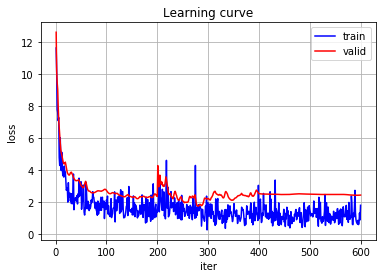

In [23]:
# Plot learning curve
plt.figure()
steps = np.arange(1, num_steps+1, 1)
plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, losses['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()
plt.title('Learning curve')
plt.grid()

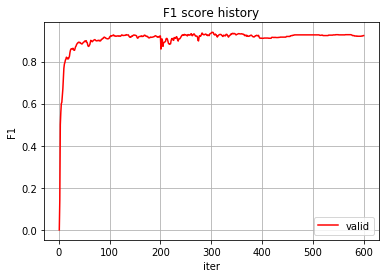

In [24]:
# Plot F1 scores
plt.figure()
steps = np.arange(1, num_steps+1, 1)
# plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, f1_scores['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('F1')
plt.legend()
plt.title('F1 score history')
plt.grid()

In [25]:
elmo_vars_dict = {v.name: v for v in elmo_vars}
saver_elmo = tf.train.Saver(elmo_vars_dict)
save_path = saver_elmo.save(sess, "./model_params/elmo.ckpt")
print("Model saved in path: %s" % save_path)
saver_all = tf.train.Saver()
save_path = saver_all.save(sess, "./model_params/model_all.ckpt")
print("Whole model saved in path: %s" % save_path)

Model saved in path: ./model_params/elmo.ckpt
Whole model saved in path: ./model_params/model_all.ckpt


In [26]:
print('Best F1 score on validation: {:.2f}'.format(best_valid_f1*100))
if TRAIN_ELMO:
    layer_coeff, scale = sess.run([elmo_coef['layer_coefficients'], elmo_coef['scaling']])
    elmo_params = {'layer_coefficients': layer_coeff, 'scaling': scale}
    elmo_layer_coeff = np.exp(elmo_params['layer_coefficients'])*elmo_params['scaling']
    print('Learned ELMo layer combination weights:')
    print(elmo_layer_coeff)
    print('Normalized:')
    print(np.exp(elmo_layer_coeff)/np.sum(np.exp(elmo_layer_coeff)))

Best F1 score on validation: 93.90
Learned ELMo layer combination weights:
[1.3286994 1.328846  0.6743314]
Normalized:
[0.39683846 0.39689666 0.20626491]


In [27]:
elmo_vars

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/proje

In [28]:
tf.trainable_variables()

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>,
 <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/proje

In [29]:
vars_dict = {v.name:v for v in tf.trainable_variables()}

In [32]:
transitions_var = vars_dict['transitions:0']

In [33]:
transitions_val = transitions_var.eval(sess)

In [38]:
print(np.exp(transitions_val)/np.sum(np.exp(transitions_val), axis=1).reshape((transitions_val.shape[0],1)))

[[0.6304114  0.36958855]
 [0.3566413  0.6433587 ]]


In [39]:
np.exp(transitions_val)

array([[1.4837615 , 0.8698784 ],
       [0.33391827, 0.6023678 ]], dtype=float32)

In [40]:
np.sum(np.exp(transitions_val), axis=1)

array([2.35364  , 0.9362861], dtype=float32)